In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 20*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh

from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2
from lidar_nerf_utils import *

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-08-16 16:00:34.674485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 16:00:34.774166: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 16:00:35.172112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2024-08-16 16:00:35.172186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7:

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-16 16:00:36.247743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-16 16:00:36.247871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20480 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:07:00.0, compute capability: 8.6


Autosaving every 180 seconds


# Manually Load and Crop Image data

In [2]:
from remove_motion_basic import linear_correction_old as lc

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
sensor_poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
sensor_poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
sensor_poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
sensor_poses = np.einsum("nij,jk->nik", sensor_poses, T_CL)
initial_pose = np.linalg.inv(sensor_poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
sensor_poses = np.einsum("ij,njk->nik", np.linalg.inv(sensor_poses[0]), sensor_poses) #TRY COMMENTING OUT...

#get body frame vel to remove motion disortion from training data
vel_world_frame = np.diff(sensor_poses[:,:3,-1], axis = 0)
vel_body_frame = np.linalg.pinv(sensor_poses[1:,:3,:3]) @ vel_world_frame[:,:,None]
vel_body_frame = vel_body_frame[:,:,0]
#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
window=50
MAx = moving_average(vel_body_frame[:,0], n = window)
MAy = moving_average(vel_body_frame[:,1], n = window)
MAz = moving_average(vel_body_frame[:,2], n = window)
vel_body_frame = np.array([MAx, MAy, MAz]).T

rot_vel_euls = np.diff(R.from_matrix(sensor_poses[:,:3,:3]).as_euler('xyz'), axis = 0)
idx = np.argwhere(rot_vel_euls > (np.pi))
rot_vel_euls[idx] = 0
idx = np.argwhere(rot_vel_euls < (-np.pi))
rot_vel_euls[idx] = 0

pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 5 #10
submap = HD_map[::show_nth]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def add_patch(rays_o, rays_d, image):    
    """given rays_o and rays_d, and a training image, 
        display the corresponding point cloud in the world frame"""
    
    #flatten first
    rays_d_flat = np.reshape(rays_d, [-1,3])
    
    #convert to spherical
    rays_d_spherical = cartesian_to_spherical(rays_d_flat).numpy()

    #reshape rays_d to same size as image
    rays_d_spherical = np.reshape(rays_d_spherical, [np.shape(rays_d)[0], np.shape(rays_d)[1], 3])
    rays_d_spherical[:,:,0] *= image
    rays_d_spherical = np.reshape(rays_d_spherical, [-1,3])
    xyz = spherical_to_cartesian(rays_d_spherical)
    
    xyz += np.reshape(rays_o, [-1,3])
    
    return xyz
        

In [ ]:
#  undistort raw point clouds, define patch sizes,
#  take patches about useful regions of the scene, and record poses for each patch 

from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 10 #220 #1000 #50 
n_rots = 16 #128    #number of horizontal patches in 360 degrees
n_vert_patches = 4 #1 #number of vertical patches between phimin and phimaxs
useICET = True #need to turn off when working with the foliage dataset???
image_width = 1024//n_rots
image_height = 64//n_vert_patches
            

# n_cols_to_skip = 0 #comment out for debug
n_cols_to_skip = n_rots // 8 #remove this much from the beginning and end of each scan
                             #   (need to remove parts of frame containing researcher carrying LIDAR)
#Ouster OS1-64
phimin = np.deg2rad(-15.594) #took forever to figure this out...
phimax = np.deg2rad(17.743)
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots*n_vert_patches,4,4])
images = np.ones([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 2]) #depth and raydrop channels
# [n total "patches", patch height, patch width, xyz]
rays_o_all = np.zeros([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 3]) 
rays_d_all = np.zeros([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 3]) 

H, W = images.shape[1:3]
redfix_hist = np.zeros([n_images,4,4]) #holds on to the corrective transforms we get from ICET 

for i in range(n_images):
    print(i) 
    #2nd courtyard
#     idx = i*60 + 1500
    #full loop first courtyard
#     idx = i + 7700 
    idx = i*100 + 7700
#     #test forest
#     idx = i*40 + 11000
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    
#     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
                      -rot_vel_euls[idx,0], #looks good
                      -rot_vel_euls[idx,1],
                      -rot_vel_euls[idx,2]
#                       0,0,0 #rotational velocity is zero-centered (theoretically should cancel out with enough data)
                     ])   
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    if useICET:
        #Register undistorted PC against HD Map using ICET to correct issues in ground truth------------------------
        submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #test
        submap_in_pc1_frame = submap_in_pc1_frame[:,:3]

        initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
        it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 8, 
           draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)

        pc1_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T #test
        pc1_in_map_frame = pc1_in_map_frame[:,:3]
    #     disp.append(Points(pc1_in_map_frame, c = 'red', r = 3, alpha = 0.2))

        pc1_corrected_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(it.cloud2_tensor.numpy(), np.ones([len(it.cloud2_tensor.numpy()),1]), axis =1).T).T #test
        pc1_corrected_in_map_frame = pc1_corrected_in_map_frame[:,:3]    
    #     disp.append(Points(pc1_corrected_in_map_frame, c = 'blue', r =3, alpha = 0.2))

        #draw red scan corrected by output of ICET
        redFix = np.eye(4)
        redFix[:3,-1] = it.X[:3]
        redFix[:3,:3] = redFix[:3,:3] @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix()
        redfix_hist[i] = redFix

        redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
    #     redScanFixed = (initial_pose @ sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
        redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
    #     disp.append(Points(redScanFixed[:,:3], c = 'red', r =3, alpha = 0.2))    
        #----------------------------------------------------------------------------------------------------------------
    else:
        redFix = np.eye(4)
        redfix_hist[i] = redFix
        redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
        redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
        
    #convert to depth image
    pc1_spherical = cartesian_to_spherical(pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
# #         #shift right -- https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts
#         data[4*k,:] = raw_data[4*k,:,0]
#         data[4*k+1,6:] = raw_data[4*k+1,:-6,0]
#         data[4*k+2,12:] = raw_data[4*k+2,:-12,0]
#         data[4*k+3,18:] = raw_data[4*k+3,:-18,0]
        # keep centered -- this is working best, though I feel like NC should have used the old firmware
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1) #do not comment out
    
    #NEW--- get rays_o and rays_d directly inside data generation loop ~~~~~~~~~~~~~~~~~~~~~~~
#     ro, rd = get_rays_from_point_cloud(pc1, m_hat, redFix) #old
    
    #test -- do frame manipulations to pc1 here...
    tempPC = np.flip(pcs, axis = 0)
    tempPC = np.reshape(tempPC, [-1,3])
    
    rotm = sensor_poses[idx] @ redfix_hist[i]
    rotm = np.linalg.pinv(initial_pose) @ rotm
    rotm[:3,-1] = np.array([-rotm[2,-1], -rotm[0,-1], rotm[1,-1]])
    #orient yellow (-z) pointing forward
    fix = np.array([[0,0,1],
                    [1,0,0],
                    [0,1,0]])
    rotm[:3,:3] = rotm[:3,:3] @ fix
    swap_axis_matrix = np.array([[0, 0, 1],
                                 [1, 0, 0],
                                 [0, 1, 0]])
    flip_axis_matrix = np.diag([1,1,-1]) # better ---> corrects flipping z issue when rendering
    rotm[:3,:3] = flip_axis_matrix @ swap_axis_matrix @ rotm[:3,:3] 

#     #center camera horizontally in each patch
#     crop_angle = j*(2*np.pi/n_rots) + (np.pi/n_rots)
#     rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()

#     rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
    
    
#     ro, rd = get_rays_from_point_cloud(tempPC, m_hat, sensor_poses[idx] @ redFix)
    ro, rd = get_rays_from_point_cloud(tempPC, m_hat, rotm)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    for j in range(n_rots):
        for k in range(n_vert_patches):
            #get cropped depth image ~~~~~~~~~~~~~~~~~~~~    
            #crop vertically and horizontally
            pcs = data[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width] 
    
            #save depth information to first channel
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] = pcs
#             images[(n_vert_patches - 1 - k)+(j+(i*n_rots))*n_vert_patches,:,:,0] = pcs #TEST -- nope

            #save raydrop mask to 2nd channel
            a = np.argwhere(abs(pcs) < 1)
            images[k+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0
#             images[(n_vert_patches - 1 - k)+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0 #TEST -- nope

            #get transformation matrix ~~~~~~~~~~~~~~~~~~
            #centers origin at actual origin of HD map 
            rotm = sensor_poses[idx] @ redfix_hist[i] #old
            rotm = np.linalg.pinv(initial_pose) @ rotm
            rotm[:3,-1] = np.array([-rotm[2,-1], -rotm[0,-1], rotm[1,-1]])
            #orient yellow (-z) pointing forward
            fix = np.array([[0,0,1],
                            [1,0,0],
                            [0,1,0]])
            rotm[:3,:3] = rotm[:3,:3] @ fix
            swap_axis_matrix = np.array([[0, 0, 1],
                                         [1, 0, 0],
                                         [0, 1, 0]])
            flip_axis_matrix = np.diag([1,1,-1]) # better ---> corrects flipping z issue when rendering
            rotm[:3,:3] = flip_axis_matrix @ swap_axis_matrix @ rotm[:3,:3] 

            #center camera horizontally in each patch
            crop_angle = j*(2*np.pi/n_rots) + (np.pi/n_rots)
            rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()

            rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

            #courtyard1
            rotm[2,-1] += 45 #translate above xy plane #COURTYARD
#             rotm[2,-1] += 300 #FOR FOREST ONLY!
            rotm[1,-1] += 30 #shift towards positive x

            #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
            rotm[:3,-1] *= 0.005 #0.005 #0.02 #0.05 #COURTYARD
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.005 #0.005 #0.02 #0.005 #0.05
#             rotm[:3,-1] *= 0.001 #FOREST ONLY
#             images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.001 #FOREST ONLY
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            # recenter (when using x0.005)
            rotm[2,-1] += 0.25 #translate above xy plane
            rotm[1,-1] += 0.25 #shift towards positive x
            rotm[0,-1] += 0.01 #TEST -- shift up just a little
            
            poses[k+(j+(i*n_rots))*n_vert_patches] = rotm 
            
            #store rays_o and rays_d info
            #TODO: transforming rays_o[cell] and rays_d[cell] by rotm??
            rd_in_patch = rd[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width, :]
            rays_d_all[k+(j+(i*n_rots))*n_vert_patches,:,:,:] = rd_in_patch
            
            ro_in_patch = ro[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width, :]
#             rays_o_all[k+(j+(i*n_rots))*n_vert_patches,:,:,:] = ro_in_patch
            rays_o_all[k+(j+(i*n_rots))*n_vert_patches,:,:,:] = rotm[:3,-1]            
            

images = images.astype(np.float32)
poses = poses.astype(np.float32)

print("num poses:", len(poses))

# # # Remove patches where sensor is occluded by person holding lidar ~~~~~~~~~~
# #calculte how many columns of patches we need to skip at the beginning and end of each scan to avoid
# print("n_rots:", n_rots)
# # n_cols_to_skip = 0 #debug
# print("n_cols_to_skip:", n_cols_to_skip)

# bad_idx = np.zeros([0,n_rots - 2*n_cols_to_skip])
# a = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
# print(np.shape(a))
# for i in range(n_vert_patches*n_cols_to_skip):
#     bad_i_left = a[i::n_rots*n_vert_patches]
#     bad_idx = np.append(bad_idx, bad_i_left)
# #     print("\n bad_idx_left:", bad_i_left)

#     bad_i_right = a[(i+n_vert_patches*(n_rots-n_cols_to_skip))::n_rots*n_vert_patches]
#     bad_idx = np.append(bad_idx, bad_i_right)
# #     print("\n bad_idx_right:", bad_i_right)
    
# bad_idx = np.sort(bad_idx)
# all_idx = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
# good_idx = np.setdiff1d(all_idx, bad_idx).astype(int)

# # print(good_idx)

# images = images[good_idx,:,:,:]
# poses = poses[good_idx,:,:]
# # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# # test on one only
# testimg, testpose = images[-1], poses[-1]
# images = images[:-1,...,:3]
# poses = poses[:-1]

# plt.show(disp, "01 Short Experiment Frame #" + str(idx))
# ViewInteractiveWidget(plt.window)

In [27]:
#trying again, much more simplified...

from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 10 #220 #1000 #50 
n_rots = 128 #128    #number of horizontal patches in 360 degrees
n_vert_patches = 1 #1 #number of vertical patches between phimin and phimaxs
useICET = True #need to turn off when working with the foliage dataset???
image_width = 1024//n_rots
image_height = 64//n_vert_patches

# n_cols_to_skip = 0 #comment out for debug
n_cols_to_skip = n_rots // 8 #remove this much from the beginning and end of each scan
                             #   (need to remove parts of frame containing researcher carrying LIDAR)
#Ouster OS1-64
phimin = np.deg2rad(-15.594) #took forever to figure this out...
phimax = np.deg2rad(17.743)
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots*n_vert_patches,4,4])
images = np.ones([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 2]) #depth and raydrop channels
# [n total "patches", patch height, patch width, xyz]
rays_o_all = np.zeros([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 3]) 
rays_d_all = np.zeros([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 3]) 

H, W = images.shape[1:3]
redfix_hist = np.zeros([n_images,4,4]) #holds on to the corrective transforms we get from ICET 

for i in range(n_images):
    print(i) 
    #full loop first courtyard
#     idx = i + 7700 
    idx = i*100 + 7700
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    
#     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
                      -rot_vel_euls[idx,0], #looks good
                      -rot_vel_euls[idx,1],
                      -rot_vel_euls[idx,2]
                     ])   
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    if useICET:
        #Register undistorted PC against HD Map using ICET to correct issues in ground truth------------------------
        submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #test
        submap_in_pc1_frame = submap_in_pc1_frame[:,:3]

        initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
        it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 8, 
           draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)

        pc1_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T #test
        pc1_in_map_frame = pc1_in_map_frame[:,:3]

        pc1_corrected_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(it.cloud2_tensor.numpy(), np.ones([len(it.cloud2_tensor.numpy()),1]), axis =1).T).T #test
        pc1_corrected_in_map_frame = pc1_corrected_in_map_frame[:,:3]    

        #draw red scan corrected by output of ICET
        redFix = np.eye(4)
        redFix[:3,-1] = it.X[:3]
        redFix[:3,:3] = redFix[:3,:3] @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix()
        redfix_hist[i] = redFix

        redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
        redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
        #----------------------------------------------------------------------------------------------------------------
    else:
        redFix = np.eye(4)
        redfix_hist[i] = redFix
        redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
        redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
        
    #convert to depth image
    pc1_spherical = cartesian_to_spherical(pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
#         #         #shift left (nope)
#         data[4*k,:-18] = raw_data[4*k,18:,0]
#         data[4*k+1,:-12] = raw_data[4*k+1,12:,0]
#         data[4*k+2,:-6] = raw_data[4*k+2,6:,0]
#         data[4*k+3,:] = raw_data[4*k+3,:,0]
# # #         #shift right -- https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts
#         data[4*k,:] = raw_data[4*k,:,0]
#         data[4*k+1,6:] = raw_data[4*k+1,:-6,0]
#         data[4*k+2,12:] = raw_data[4*k+2,:-12,0]
#         data[4*k+3,18:] = raw_data[4*k+3,:-18,0]
        #keep centered
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1) #do not comment out

#     #test not correcting bus-delay induced skew in raw data
#     data = np.flip(raw_data, axis =1)[:,:,0] #do not comment out
# #     data = raw_data[:,:,0]
    
    #NEW--- get rays_o and rays_d directly inside data generation loop ~~~~~~~~~~~~~~~~~~~~~~~
    
    rotm = sensor_poses[idx] @ redfix_hist[i]
    rotm = np.linalg.pinv(initial_pose) @ rotm

    #courtyard1
    rotm[2,-1] += 15 
    rotm[1,-1] += 30
    rotm[0,-1] += 30
    rotm[:3,-1] *= 0.005 #0.005 #0.02 #0.05 #COURTYARD
    # recenter (when using x0.005)
    rotm[2,-1] += 0.25 #translate above xy plane
    rotm[1,-1] += 0.25 #shift towards positive x
    rotm[0,-1] += 0.01 #TEST -- shift up just a little
    
#     print(data)
    
    ro, rd = get_rays_from_point_cloud(pc1, m_hat, rotm)
    print("rd", rd)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    for j in range(n_rots):
        for k in range(n_vert_patches):
            
            #store rays_o and rays_d info
            rd_in_patch = rd[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width, :]
            rays_d_all[k+(j+(i*n_rots))*n_vert_patches,:,:,:] = rd_in_patch
            ro_in_patch = ro[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width, :]
            rays_o_all[k+(j+(i*n_rots))*n_vert_patches,:,:,:] = ro_in_patch            
            
            #get cropped depth image ~~~~~~~~~~~~~~~~~~~~    
            #crop vertically and horizontally
            pcs = data[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width] 
    
            #save depth information to first channel
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] = pcs
            #save raydrop mask to 2nd channel
            a = np.argwhere(abs(pcs) < 1)
            images[k+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0

            #get transformation matrix ~~~~~~~~~~~~~~~~~~
            #centers origin at actual origin of HD map 
            rotm = sensor_poses[idx] @ redfix_hist[i] #old
            rotm = np.linalg.pinv(initial_pose) @ rotm
            rotm[:3,-1] = np.array([-rotm[2,-1], -rotm[0,-1], rotm[1,-1]])
            #orient yellow (-z) pointing forward
            fix = np.array([[0,0,1],
                            [1,0,0],
                            [0,1,0]])
            rotm[:3,:3] = rotm[:3,:3] @ fix
            swap_axis_matrix = np.array([[0, 0, 1],
                                         [1, 0, 0],
                                         [0, 1, 0]])
            flip_axis_matrix = np.diag([1,1,-1]) # better ---> corrects flipping z issue when rendering
            rotm[:3,:3] = flip_axis_matrix @ swap_axis_matrix @ rotm[:3,:3] 

            #center camera horizontally in each patch
            crop_angle = j*(2*np.pi/n_rots) + (np.pi/n_rots)
            rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()

            rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
            
            #courtyard1
            rotm[2,-1] += 15 
            rotm[1,-1] += 30
            rotm[0,-1] += 30
            rotm[:3,-1] *= 0.005 #0.005 #0.02 #0.05 #COURTYARD
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.005 #0.005 #0.02 #0.005 #0.05
            # recenter (when using x0.005)
            rotm[2,-1] += 0.25 #translate above xy plane
            rotm[1,-1] += 0.25 #shift towards positive x
            rotm[0,-1] += 0.01 #TEST -- shift up just a little

            poses[k+(j+(i*n_rots))*n_vert_patches] = rotm 
            
images = images.astype(np.float32)
poses = poses.astype(np.float32)

0
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([-0.04476087  0.01387104 -0.0153338   0.00439186 -0.00039462 -0.0014049 ], shape=(6,), dtype=float32)
before tf.Tensor([ 0.        0.        0.       ... 23.599155 23.972824 24.3182  ], shape=(65536,), dtype=float32)
after tf.Tensor([ 1.        1.        1.       ... 23.599155 23.972824 24.3182  ], shape=(65536,), dtype=float32)
dirs_undistorted (65536, 3)
rays_o (64, 1024, 3)
rays_d (64, 1024, 3)
rd tf.Tensor(
[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.

8
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.13198885  0.00099686  0.02483766  0.00795206 -0.00078187 -0.03743674], shape=(6,), dtype=float32)
before tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(65536,), dtype=float32)
after tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(65536,), dtype=float32)
dirs_undistorted (65536, 3)
rays_o (64, 1024, 3)
rays_d (64, 1024, 3)
rd tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(64, 1024, 3), dtype=float32)
9
iter 0


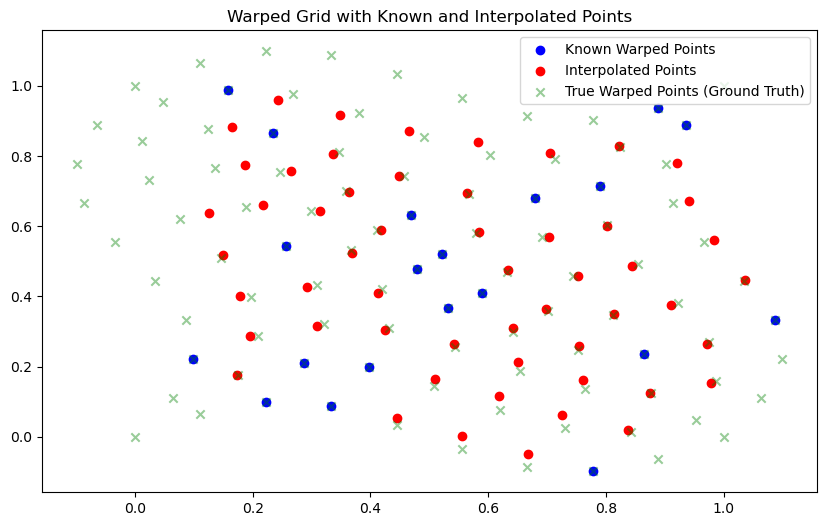

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Generate a regular 2D grid (source grid)
grid_size = 10  # Size of the grid
source_grid_x, source_grid_y = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
source_points = np.column_stack((source_grid_x.flatten(), source_grid_y.flatten()))

# Create a warp transformation (e.g., simple non-linear warp)
def warp_function(x, y):
    # Example warp: simple distortion
    return x + 0.1 * np.sin(2 * np.pi * y), y + 0.1 * np.sin(2 * np.pi * x)

# Warp some of the points
warped_points = np.array([warp_function(x, y) for x, y in source_points])

# Select known warped points (subset for interpolation)
known_indices = np.random.choice(len(source_points), size=20, replace=False)
known_source_points = source_points[known_indices]
known_warped_points = warped_points[known_indices]

# Interpolate missing points on the warped grid
missing_indices = np.setdiff1d(np.arange(len(source_points)), known_indices)  # Remaining points
missing_source_points = source_points[missing_indices]

# Use griddata to estimate locations of missing points on the warped grid
interpolated_points = griddata(known_source_points, known_warped_points, missing_source_points, method='cubic')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(*zip(*known_warped_points), color='blue', label='Known Warped Points')
plt.scatter(*zip(*interpolated_points), color='red', label='Interpolated Points')
plt.scatter(*zip(*warped_points), color='green', marker='x', alpha=0.4, label='True Warped Points (Ground Truth)')
plt.legend()
plt.title("Warped Grid with Known and Interpolated Points")
plt.show()


source_points: (65536, 2)
warped_points (65536, 2)


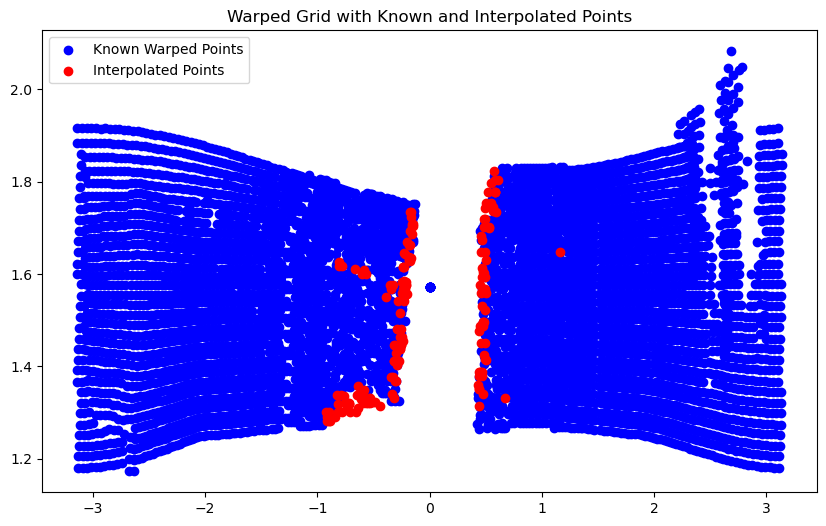

In [218]:
idx = 8200
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
m_hat = np.array([3.,0,0,0,0,0.])
pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)

pc1_spherical = cartesian_to_spherical(pc1)
ray_drops = tf.where(pc1_spherical[:,0]<0.001)
non_ray_drops = tf.where(pc1_spherical[:,0]>0.001)

# Generate a regular 2D grid (source grid)
source_grid_x, source_grid_y = np.meshgrid(np.linspace(0, 63, 64), np.linspace(0, 1023, 1024))
source_points = np.column_stack((source_grid_x.flatten(), source_grid_y.flatten()))
print("source_points:", np.shape(source_points))

# Warp some of the points
# warped_points = tf.gather_nd(pc1_spherical, non_ray_drops).numpy()
warped_points = pc1_spherical[:,1:].numpy()
print("warped_points", np.shape(warped_points))

# Select known warped points (subset for interpolation)
known_indices = non_ray_drops[:,0]
known_source_points = source_points[known_indices]
known_warped_points = warped_points[known_indices]

# Interpolate missing points on the warped grid
missing_indices = np.setdiff1d(np.arange(len(source_points)), known_indices)  # Remaining points
missing_source_points = source_points[missing_indices]

# Use griddata to estimate locations of missing points on the warped grid
interpolated_points = griddata(known_source_points, known_warped_points, missing_source_points, method='cubic')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(*zip(*known_warped_points[::10]), color='blue', label='Known Warped Points')
plt.scatter(*zip(*interpolated_points[::10]), color='red', label='Interpolated Points')
# plt.scatter(*zip(*warped_points[::10]), color='green', marker='x', alpha=0.4, label='True Warped Points (Ground Truth)')
plt.legend()
plt.title("Warped Grid with Known and Interpolated Points")
plt.show()

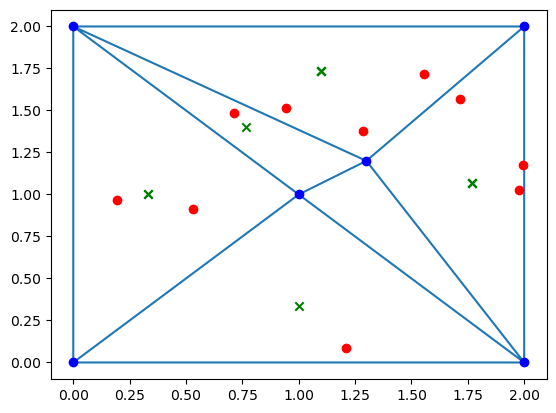

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Known grid points with irregular spacing
known_points = np.array([[0, 0], [2, 0], [1.3,1.2], [1, 1], [0, 2], [2, 2]])

# Missing points (you want to determine their positions)
missing_indices = 2 * np.random.rand(10, 2)

# Perform Delaunay triangulation
tri = Delaunay(known_points)

# Plot the triangulation
fig, ax = plt.subplots()
ax.triplot(known_points[:, 0], known_points[:, 1], tri.simplices)
ax.scatter(known_points[:, 0], known_points[:, 1], color='blue', label='Known Points')
ax.scatter(missing_indices[:, 0], missing_indices[:, 1], color='red', label='Missing Points')

# Interpolating positions within the triangles could be done here
# This requires finding which triangle the missing points fall into
for point in missing_indices:
    simplex = tri.find_simplex(point)
    if simplex >= 0:
        vertices = tri.simplices[simplex]
        interpolated_position = np.mean(known_points[vertices], axis=0)  # Simple averaging for demo
        ax.scatter(*interpolated_position, color='green', marker='x', label='Interpolated Position')

# ax.legend()
plt.show()

# Debug rays_o, rays_d

In [28]:
def draw_frame_from_rays(disp, n_rots=128, n_vert_patches=1, frameIdx=0, color = 'red'):

    phimin = np.deg2rad(-15.594) #took forever to figure this out...
    phimax = np.deg2rad(17.743)
    H = 64 // n_vert_patches
    W = 1024 // n_rots
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
    phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

    pts1 = np.zeros([1,3])
    for p in range(frameIdx*n_rots, (frameIdx + 1 )*n_rots):
        for i in range(n_vert_patches):
            img_i = i
            idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
            idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
            phimin_patch = phivals[idx_first]
            phimax_patch = phivals[idx_second]

            pose = poses[i + p*n_vert_patches]
            rays_o = rays_o_all[i + p*n_vert_patches]
            rays_d = rays_d_all[i + p*n_vert_patches]

            inMap1 = add_patch(rays_o, rays_d, images[i+p*n_vert_patches,:,:,0])

            pts1 = np.append(pts1, inMap1, axis = 0)
        disp.append(Points(rays_o[0,:1,:], r = 15, c = 'purple')) #DEBUG 

    vizPts1 = Points(pts1, c = color, r = 3., alpha = 0.125)
    disp.append(vizPts1)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]          

# colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'red']
colors = np.linspace(0.1,0.3,n_images)[:,None] * np.array([[1,1,1]])
for i in range(len(colors)):
    print(i)
    draw_frame_from_rays(disp, n_rots = 128, n_vert_patches=1, frameIdx = i, color=colors[i])

plt.show(disp, "debugging rays_o and rays_d")
ViewInteractiveWidget(plt.window)  

0
1
2
3
4
5
6
7
8
9


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

### NEW-- get rays_o and rays_d directly from distortion corrected point cloud
#### old method of assuming rays based on lidar index was preventing motion distortion correction from working!!!


In [25]:
#draw subsequent scans aligned using poses with redfix
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for i in range(10):
    idx = i*100 + 7700
#     idx = i*100 + 11000
    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
# #     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#      #looks great!
#     m_hat = np.array([-vel_body_frame[idx,0],
#                       -vel_body_frame[idx,1],
#                       -vel_body_frame[idx,2],
#                       -rot_vel_euls[idx,0],
#                       -rot_vel_euls[idx,1],
#                       -rot_vel_euls[idx,2]
#                      ])   
#     pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
# #     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        

    #centers origin at actual origin of HD map 
    rotm = sensor_poses[idx] @ redfix_hist[i]
    rotm = np.linalg.pinv(initial_pose) @ rotm

    pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
        
    disp.append(Points(pc1_aligned[:,:3], c = 'r', r = 2.5, alpha = 0.125))
    
plt.show(disp, "Training Data with VICET correction")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [ ]:
#debug applying motion profile to rays_d-- 
# need to get it to match how we are applying it to pc1
from lidar_nerf_utils import get_rays_from_point_cloud

idx = 7750
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)

# m_hat = np.array([-vel_body_frame[idx,0],
#                   -vel_body_frame[idx,1],
#                   -vel_body_frame[idx,2],
#                   -rot_vel_euls[idx,0],
#                   -rot_vel_euls[idx,1],
#                   -rot_vel_euls[idx,2]
#                  ])   
m_hat = np.array([-1,0,0,0,0,0])
pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)

c2w = tf.cast(np.eye(4), tf.float32) #DEBUG ONLY
ro, rd = get_rays_from_point_cloud(m_hat, c2w)

#draw
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
# disp.append(Points(pc1[:30000], c = 'r', r = 2.5, alpha = 0.125))   
disp.append(Points(pc1, c = 'r', r = 2.5, alpha = 0.125))   
disp.append(Points(tf.reshape(rd, [-1,3]), c = 'b', r = 2.5, alpha = 0.125))   
# disp.append(Points(tf.reshape(rd, [-1,3])[:200], c = 'r', r = 10, alpha = 0.125))   
plt.show(disp, "getting rays_d from raw point cloud")
ViewInteractiveWidget(plt.window)

In [ ]:
#draw subsequent scans aligned using poses without redfix
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for i in range(10):
    idx = i*100 + 7700
#     idx = i*100 + 11000
    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)      

    #centers origin at actual origin of HD map 
    rotm = sensor_poses[idx]
    rotm = np.linalg.pinv(initial_pose) @ rotm

    pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
        
    disp.append(Points(pc1_aligned[:,:3], c = 'b', r = 2.5, alpha = 0.125))
    
plt.show(disp, "Training Data with raw \"ground truth\" poses")
ViewInteractiveWidget(plt.window)

In [ ]:
H = 64
W = 1024
phimax_patch = np.deg2rad(-15.594) #works best flipped
phimin_patch = np.deg2rad(17.743)

i, j = tf.meshgrid(tf.range(1024, dtype=tf.float32), tf.range(64, dtype=tf.float32), indexing='xy')
test = (-(i - ((W-1)/2))  /(W) * (2*np.pi/(1024//(W))) - 2*np.pi )  % (2*np.pi) - np.pi
# test = (i - ((W-1)/2))  /(W) * (2*np.pi/(1024//(W))) - np.pi
print(test)

idx  = 7800
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
pc1_spherical = cartesian_to_spherical(pc1)

fig, ax = p.subplots(2,1)
ax[0].plot(test[0,:])
# ax[0].plot(np.flip(test, axis = 1)[0,:])
ax[1].plot(pc1_spherical[:,1])

In [ ]:
#LOAD [-15,17.5]x1000, @0.005
# poses = np.load("/home/derm/Desktop/poses.npy") # <--- used these for best NeRF training
# images = np.load("/home/derm/Desktop/images.npy")
# poses = np.load("/home/derm/Desktop/posesEval.npy") # <--- every 5th frame, [7700:8800] for benchmarking
# images = np.load("/home/derm/Desktop/imagesEval.npy")

# #forest sample
# poses = np.load("/home/derm/Desktop/posesForest.npy")
# images = np.load("/home/derm/Desktop/imagesForest.npy")

# #LOAD [-15,17]x1000, 8x8 @ 0.005
poses = np.load("/home/derm/Desktop/poses8x8.npy")
images = np.load("/home/derm/Desktop/images8x8.npy")

# #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
# rotm[:3,-1] *= 0.002 #0.005 #0.02 #0.05
# images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.002 #0.005 #0.02 #0.005 #0.05
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Train NeRF using old single-network strategy

### TODO: Bug is in here! For some reason, changing patch sizes is changing rotation angles!

In [ ]:
phimin = np.deg2rad(-15.594) #observed in raw data 
phimax = np.deg2rad(17.743) #observed in raw data
# phimin = -0.3
# phimax = 0.1

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[] 

#look at each pose
# dummy = np.zeros([10,3])
for p in range(2):
    n_rots = 128 #128 #number of horizontal patches per 2*pi
    n_vert_patches = 1 #8 #1 #number of vertical patches between phimin and phimax
    H = 64 // n_vert_patches
    W = 1024 // n_rots
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
    phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles
    for i in range(n_vert_patches):
#         print("\n i:", i)
        img_i = i

        #top to bottom (correct)
        idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
        idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
        phimin_patch = phivals[idx_first]
        phimax_patch = phivals[idx_second]

#         #bottom to top (incorrect)
#         idx_first = (img_i + 1) * (64 // n_vert_patches) - 1
#         idx_second = img_i * (64 // n_vert_patches)
#         idx_first %= len(phivals)
#         idx_second %= len(phivals)
#         phimin_patch = phivals[idx_first]
#         phimax_patch = phivals[idx_second]

        print(idx_first, idx_second)    
        print(phimin_patch, phimax_patch)

    #     pose = tf.cast(np.eye(4), tf.float32)
        pose = poses[i + p*n_vert_patches]
        rays_o, rays_d, rays_d_OG = get_rays(H, W, pose, phimin_patch, phimax_patch, debug=True)
        print(rays_d[:,0])
        
        rotm = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix()
        rot_test = rays_d_OG @ rotm @ pose[:3,:3]

        disp.append(Points(tf.reshape(rays_d.numpy(), [-1,3]), c = 'k', alpha = (i+1)/8, r = 3.5))
        disp.append(Points(tf.reshape(rays_d.numpy(), [-1,3])[:10,:], c = 'red', r = 3.5, alpha =  0.6))
        
        disp.append(Points(tf.reshape(rays_d_OG, [-1,3]), c = 'g', r = 3.5, alpha = 0.5))
#         disp.append(Points(tf.reshape(rot_test, [-1,3]), c = 'g', r = 3.5, alpha = 0.5))
    
    n_rots = 128 #128 #number of horizontal patches per 2*pi
    n_vert_patches = 1 #8 #1 #number of vertical patches between phimin and phimax
    H = 64 // n_vert_patches
    W = 1024 // n_rots
    # pose = tf.cast(np.eye(4), tf.float32)
    pose = poses[i + p*8]
    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
#     print(idx_first, idx_second)    
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]
    rays_o, rays_d2 = get_rays(H, W, pose, phimin_patch, phimax_patch)
#     disp.append(Points(tf.reshape(rays_d2, [-1,3]), c = 'b', r = 15., alpha = 0.1))
    print(phimin_patch, phimax_patch)
    print(rays_d2[:,0])
    print(np.shape(tf.reshape(rays_d2, [-1,3])))
    for i in range(8):
#         print(np.linspace(0,63,64)[8*i:8*(i+1)])
#         disp.append(Points(tf.reshape(rays_d2, [-1,3])[64*i:64*(i+1),:], c = 'b', r = 15., alpha = i/8))
        disp.append(Points(tf.reshape(rays_d2, [-1,3])[64*i:64*i + 10,:], c = 'b', r = 15., alpha = (i+1)/8))

plt.show(disp, "single vs multiple patches")
ViewInteractiveWidget(plt.window)
# print(rays_d[:,0])

In [ ]:
# fig, ax = p.subplots(1,2)

# stacked = np.zeros([0,8])
# print(np.shape(images))
# for i in range(8):
#     stacked = np.append(stacked, images[i,:,:,0], axis = 0)

# ax[0].imshow(stacked)
# ax[1].imshow(images[1,:,:,0])

In [ ]:
from lidar_nerf_utils import *
from numpy.lib.stride_tricks import sliding_window_view

model = init_model()
# optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
optimizer = tf.keras.optimizers.Adam(1e-4)
# optimizer = tf.keras.optimizers.Adam(5e-5) #anneal to this (LiDAR NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-5)
# optimizer = tf.keras.optimizers.Adam(5e-6) #anneal to this (Mip-NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-6) #TEST

N_samples = 128 #128
near=0.
far= 1.
N_iters = 5_000_000
psnrs = []
iternums = []
i_plot = 64
accumulate_gradients_steps = 1 #32
# runfine = True
runfine = False

#IMPORTANT-- this needs to match values used when setting up training data 
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #1 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots
testimg = images[12]
testpose = poses[12]

phimin = np.deg2rad(-15.594) #observed in raw data 
phimax = np.deg2rad(17.743) #observed in raw data

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

gradients = [tf.zeros_like(var) for var in model.trainable_variables]
accumulated_loss = 0.0

for i in range(N_iters+1):
#     print(i)
    img_i = np.random.randint(images.shape[0])
#     img_i = i #DEBUG
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]

#     target = np.flip(target, axis =0) #test flipping vertically -- nope
#     target_drop_mask = np.flip(target_drop_mask, axis =0) #test flipping vertically -- nope
        
    #top to bottom (correct)
    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]
#     print("i", i, "\n", idx_first, idx_second)
#     print("i", i, "\n", phimin_patch, phimax_patch)
    
    #get ray origins and ray directions
    #old method-- assumes equal spacing between all points (wrong)
#     rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch) 
    #new method-- precalculate origin and view direction of points from raw data
    rays_o = rays_d_all[img_i]
    rays_d = rays_o_all[img_i]
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
#         z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        loss_coarse = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF) #punish similar depth returns
        loss = loss_coarse
                  
        #NEW--prevent NaN gradients from crashing training routine(?) -- needed for monotonically increasing outputs?
        current_gradients = tape.gradient(loss, model.trainable_variables)
        current_gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(current_gradients, model.trainable_variables)]
        gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]        

        # #OLD-- not working with CDF stuff
        # current_gradients = tape.gradient(loss, model.trainable_variables)
        # gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]    
        
        accumulated_loss += loss
    
    if i%accumulate_gradients_steps==0:    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accumulated_loss = 0.0
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]
        accumulated_loss = 0
    
    if i%i_plot==0:
#         rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        # loss = calculate_loss(depth, ray_drop, target, target_drop_mask)
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

# Infer cloud at novel frame

In [ ]:
num_view = 128 #128 #number of (rotational?) patches to draw
N_samples = 128 #128 #2048 #does not have to match what was used in training
near=0.
far= 1. #0.25 #2.
n_rots = 128 #128 #number |of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
phimin = np.deg2rad(-15.593) #was this
phimax = np.deg2rad(17.743)
# phimin = np.deg2rad(-17.743) #TEST
# phimax = np.deg2rad(15.593) #TEST

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save poitn cloud to external file

very_beginning = time.time()

for j in range(num_view):
# for j in range(12,116):
    before = time.time()
    #get sensor transformation matrix
    rotm = np.eye(4)

    # account for image crop in rotation -------------------
    crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots)
    rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

#     #need to account for the fact that the LIDAR beam isn't actually centered at horizon
#     sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
#     rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
    # ------------------------------------------------------

    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
#     #main courtyard
#     rotm[2,-1] = 0.325  #x in world frame output
#     rotm[0,-1] = 0.008 #z in world frame output
#     rotm[1,-1] = 0.325  #y in world frame
    rotm[2,-1] = 0.45  #x in world frame output
    rotm[0,-1] = 0.01 #z in world frame output
    rotm[1,-1] = 0.40  #y in world frame
#     rotm[2,-1] = 0.2656  #x in world frame output     #starting orientation
#     rotm[0,-1] = 0.006 #0.0086 #z in world frame output
#     rotm[1,-1] = 0.3254  #y in world frame
# #     #forest
#     rotm[2,-1] = 0.299  #x in world frame output
#     rotm[0,-1] = 0.012 #z in world frame output
#     rotm[1,-1] = 0.365  #y in world frame

    rotm = rotm.astype(np.float32)
    
#     vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
#     phimin_patch = vertical_bins[img_i%n_vert_patches] 
#     phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
# #     print(phimin_patch, phimax_patch)

    phimin_patch = phimin
    phimax_patch = phimax

    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
#     depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
    z_vals = tf.linspace(near, far, N_samples) 
    z_vals += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals = z_vals[:,:,:,None]
    
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
    elapsed = time.time() - before
#     print("1 forward pass took ", elapsed, "s")
    begin_other = time.time()
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    #scale back up to normal size
    depth *= 200 #courtyard only
#     depth *= 1000 #forest
    ray_drop = tf.transpose(ray_drop).numpy()
    ray_drop = np.flip(ray_drop, axis = 0)
    
    count = 0
    for w in range(W):
        for h in range(H):
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
            if ray_drop[w,h] > 0.9:             
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
            count+= 1

    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) + np.pi #was this
#     new_point_cloud_spherical[:,1] -= (np.pi/n_rots) + j*(2*np.pi/n_rots) + np.pi #test
    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
#     new_point_cloud_cart[:,1] = -new_point_cloud_cart[:,1] #flip another axis to get back to LHCS (synthetic data only?)

    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
#     # rainbow by z height
#     zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
#     cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
#     disp.append(Points(new_point_cloud_cart, c = cname, r = 2, alpha = 0.5))
    savepc = np.append(savepc, new_point_cloud_cart, axis = 0)
#     print("took ", time.time() - begin_other, "s to do the rest")

#get rid of points at origin
d = np.sqrt(np.sum(savepc**2, axis = 1))
print(np.shape(d))
good  = np.argwhere(d > 1)[:,0]
savepc = savepc[good]


print("took: ", time.time() - very_beginning,"s overall")
# print(testpose)
# print("\n", rotm)
plt.show(disp, "Old Coarse-to-Fine on Single Network")
ViewInteractiveWidget(plt.window)

In [ ]:
temp = np.zeros([np.shape(images)[1],0])
print(np.shape(temp))
for img_i in range(0,50):
    temp = np.append(temp,images[img_i,:,:,0], axis = 1)

fig, ax = p.subplots(3,1)
ax[0].axis('off')
ax[0].imshow(temp)
ax[0].set_title("Depth Image")

thresh_horiz = 0.05 #test 
thresh_vert = 0.005 #test
temp = temp[:,:,None]
mask = np.ones(np.shape(temp[:,:,0]))
vertical_grad_target = np.gradient(temp[:,:,0])[0] 
vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh_vert) #old
mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 0 #1
horizontal_grad_target = np.gradient(target[:,:,0])[1]
horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh_horiz) #old
mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 0 #1

ax[1].imshow(mask)
ax[1].set_title("Gradient Mask")
ax[1].axis('off')

# #TEST ~~~ prevent gradient mask from getting rid of double returns in windows, etc.
save_non_ground = tf.zeros_like(mask).numpy()
save_non_ground[:40,:] = 1 #prevent anything in the top ~3/4 of image from getting masked
save_non_groud = tf.convert_to_tensor(save_non_ground)
together = tf.concat([save_non_groud[:,:,None], mask[:,:,None]], axis = -1)
mask = tf.math.reduce_max(together, axis = -1)
mask = tf.cast(mask, tf.float32)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax[2].imshow(mask)
ax[2].set_title("Gradient Mask, Preserving High 2nd Derivatives")
ax[2].axis('off')

# Test creating arbitrary bins for coarse and fine network outputs

### Left Riemann Sum

In [ ]:
n_bins_coarse = 7
bins_coarse = np.linspace(0,1,n_bins_coarse)
# bins_coarse = bins_coarse**2#TEST
w_coarse = np.gradient(bins_coarse)
print(bins_coarse)
print(w_coarse)
w_coarse[-1] = 0
vals_coarse = abs(1/(0.6 - bins_coarse))
vals_coarse = vals_coarse/np.sum(vals_coarse*w_coarse)

n_bins_fine = 30
bins_fine = np.linspace(0,1,n_bins_fine)**0.5
# bins_fine = np.sin(np.linspace(0,1,n_bins_fine))
vals_fine = abs(1/((0.6 - bins_fine)*(0.9 - bins_fine)))
w_fine = np.diff(bins_fine)
w_fine = np.append(w_fine, 0)
vals_fine = vals_fine/np.sum(vals_fine*w_fine)

In [ ]:
from matplotlib import pyplot as p
fig, ax = p.subplots()

ax.bar(bins_coarse+w_coarse/2, vals_coarse , width = w_coarse, 
       color ='red', edgecolor = 'black', label = "coarse (normalized)", alpha = 0.5);
ax.bar(bins_fine+w_fine/2, vals_fine, width = w_fine, color = 'blue', 
       label = "fine", edgecolor = 'black', alpha = 0.5);
ax.scatter(bins_coarse, vals_coarse, color = 'red')
ax.scatter(bins_fine, vals_fine, color = 'blue')

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper left")

In [ ]:
#Calculate loss for a given region in the coarse histogram
# print(bins_coarse)
# print(bins_fine)
# print(np.sum(vals_coarse), np.sum(vals_fine))

L = np.zeros(len(bins_coarse))
for i in range(len(bins_coarse) - 1):
    #get sample locations in fine distribution that fall within bin i of coarse distribution
    small_enough_idx = np.where(bins_fine < bins_coarse[i+1])
    big_enough_idx = np.where(bins_fine >= bins_coarse[i])
    idx_in_range = np.intersect1d(small_enough_idx, big_enough_idx)

    fine_in_bin = np.sum(vals_fine[idx_in_range]*w_fine[idx_in_range])
#     print("\n coarse at i: ", vals_coarse[i]*w_coarse[i])
#     print("val fine in bin i:", fine_in_bin)
#     print("fine at i:", fine_in_bin)
  
    L[i] = max(0, fine_in_bin -  vals_coarse[i]*w_coarse[i])
    print("L[i]", L[i])
print(np.sum(L))

### With centered bins

In [ ]:
n_bins_coarse = 10
bins_coarse = np.linspace(0,1,n_bins_coarse)

# # bins_coarse = bins_coarse**2
# bins_coarse = np.cumsum(abs(np.sin(10*bins_coarse)))
# bins_coarse /= bins_coarse[-1]

w_coarse = np.diff(bins_coarse)
w_coarse = np.append(w_coarse, 0)
bins_coarse = bins_coarse+w_coarse/2
# w_coarse[-1] = 0
vals_coarse = abs(1/(0.6 - bins_coarse))
vals_coarse = vals_coarse/np.sum(vals_coarse*w_coarse)

print("bins_coarse:\n", bins_coarse)
print("w_coarse:\n", w_coarse)

n_bins_fine = 30
bins_fine = np.linspace(0,1,n_bins_fine)**0.5
# bins_fine = np.sin(np.linspace(0,1,n_bins_fine))
vals_fine = abs(1/((0.6 - bins_fine)*(0.9 - bins_fine)))
w_fine = np.diff(bins_fine)
w_fine = np.append(w_fine, 0)
bins_fine = bins_fine+w_fine/2
vals_fine = vals_fine/np.sum(vals_fine*w_fine)

from matplotlib import pyplot as p
fig, ax = p.subplots()

ax.bar(bins_coarse, vals_coarse , width = w_coarse, 
       color ='red', edgecolor = 'black', label = "coarse (normalized)", alpha = 0.5);
ax.bar(bins_fine, vals_fine, width = w_fine, color = 'blue', 
       label = "fine", edgecolor = 'black', alpha = 0.5);
ax.scatter(bins_coarse, vals_coarse, color = 'red')
ax.scatter(bins_fine, vals_fine, color = 'blue')

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper left")

L = np.zeros(len(bins_coarse))
for i in range(len(bins_coarse) - 1):
    #get sample locations in fine distribution that fall within bin i of coarse distribution    
#     print(bins_coarse[i]-(w_coarse[i]/2), (bins_coarse[i]+(w_coarse[i+1]/2)))
    small_enough_idx = np.where(bins_fine < (bins_coarse[i]+(w_coarse[i+1]/2)))
    big_enough_idx = np.where(bins_fine >= bins_coarse[i]-(w_coarse[i]/2))

    idx_in_range = np.intersect1d(small_enough_idx, big_enough_idx)

    fine_in_bin = np.sum(vals_fine[idx_in_range]*w_fine[idx_in_range])
#     print("\n coarse at i: ", vals_coarse[i]*w_coarse[i])
#     print("val fine in bin i:", fine_in_bin)
#     print("fine at i:", fine_in_bin)
  
    L[i] = max(0, fine_in_bin -  vals_coarse[i]*w_coarse[i])
    print("L[i]", L[i])
print(np.sum(L))

# Recreating the above process in parallel using tensorflow

In [ ]:
import tensorflow_probability as tfp
#make arbitrary fine distributions (what the fine netork of the scene)
#  these vary in inferred density as well as sampling location
H = 64
W = 8
n_bins_fine = 64
n_bins_coarse = 8

#create random sinusoidal peaks
randy = np.pi*tf.random.uniform([H,W, 2])
randy2 = np.pi*tf.cast(tf.random.uniform([H,W, 2]),tf.float32) 

# print(np.shape(randy))
lin = tf.cast(tf.linspace(0,1,n_bins_fine), tf.float32)
lin = tf.tile(lin[None,None,:,None], [H,W,1,1])
weights_fine = (tf.math.sin(randy[...,:1,None]*np.pi*lin + randy[...,1:2,None]) +1)/2

z_vals_coarse = tf.cast(tf.linspace(0,1,n_bins_coarse), tf.float32)
#TEST -- nonlinear z values for coarse network -- looks like it works!
# z_vals_coarse = z_vals_coarse**2 
# z_vals_coarse = tf.math.sin(z_vals_coarse)
z_vals_coarse = tf.tile(z_vals_coarse[None,None,:,None], [H,W,1,1])
# print(np.shape(z_vals_coarse))
weights_coarse = (tf.math.sin(randy[...,:1,None]*np.pi*z_vals_coarse + randy[...,1:2,None]) +1)/2
weights_coarse = weights_coarse/tf.math.reduce_sum(weights_coarse, axis = 2)[:,:,:,None] #normalize to sum to 1
# print(np.shape(weights_coarse))
# print(np.shape(weights_fine))

w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_coarse = tf.pad(w_coarse, padding_config, constant_values=0.001)
#shift definition of z_vals to the center (for centered Riemann Sums)

#init z_vals [h, w, n_samples, 1]
#create inconsistant spacing for z vals in fine rays
#same as "bins_fine" in previous
z_vals_fine = (tf.math.sin(3*np.pi*randy2[...,:1,None]*lin + randy2[...,1:,None]) + 2 ) /3
# z_vals = (tf.math.sin(np.pi*randy2[:,:1]*lin + randy2[:,1:]) + 1 ) /2
z_vals_fine = tf.cumsum(z_vals_fine, axis = -2)
# print("z_vals", np.shape(z_vals))
z_vals_fine -= z_vals_fine[:,:,:1,:]
z_vals_fine /= z_vals_fine[:,:,-1:,:]
# print("test", np.shape(z_vals_fine[:,:,-1:,:]))
# print(z_vals[0,0,:,0])


w_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_fine = tf.pad(w_fine, padding_config, constant_values=0.001)

#shift z_vals def to the center
z_vals_coarse = z_vals_coarse + w_coarse/2 
z_vals_fine = z_vals_fine + w_fine/2 

# #TEST -- renormalize fine widths ~~~~~~~
# w_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
# padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
# w_fine = tf.pad(w_fine, padding_config, constant_values=0.001)
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#correct weights so area under the curve is 1
area_fine = tf.math.reduce_sum(weights_fine * w_fine, axis = 2)[:,:,:,None]
weights_fine = weights_fine/area_fine
# print(tf.math.reduce_sum(weights_fine*w_fine, axis = 2))

area_coarse = tf.math.reduce_sum(weights_coarse * w_coarse, axis =2)[:,:,:,None]
weights_coarse = weights_coarse/area_coarse
# print(tf.math.reduce_sum(weights_coarse*w_coarse, axis = 2))

print(w_coarse[0,0,:,0])
print(tf.experimental.numpy.diff(z_vals_coarse, axis = 2)[0,0,:,0]) #<--- slightly different at very end

In [ ]:
def my_gradient_tf(a):
    rght = tf.concat((a[..., 1:], tf.expand_dims(a[..., -1], -1)), -1)
    left = tf.concat((tf.expand_dims(a[...,0], -1), a[..., :-1]), -1)
    ones = tf.ones_like(rght[..., 2:], tf.float32)
    one = tf.expand_dims(ones[...,0], -1)
    divi = tf.concat((one, ones*2, one), -1)
#     print(left[0,0,:])
#     print(rght[0,0,:])

    test = tf.concat((a[...,1:], tf.ones_like(a[:,:,:1])), axis = -1) - a
    print(test[0,0,:])
    
    return (rght-left) / divi

g = my_gradient_tf(z_vals_coarse[:,:,:,0])
print(g[0,0,:])

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~
look_at = 0

#left riemann sums (old)
# zc = z_vals_coarse[look_at,0,:,0] 
zf = z_vals_fine[look_at,0,:,0]
#shift for centered riemann sums -- see if center of fine fits within left and right limits of coarse 
zc = z_vals_coarse[look_at,0,:,0] - w_coarse[look_at,0,:,0]/2 
zf = z_vals_fine[look_at,0,:,0]

# print("zc \n", zc)
# print("zf \n", zf)

#get index of which bin in coarse each bar in fine belongs inside of
indices = tf.searchsorted(zc, zf, side='right')-1
# print("idx: \n", indices)

#need to scale L_i by width of coarse bins
fine_sum = tf.math.segment_sum(weights_fine[look_at,0,:,0]*w_fine[look_at,0,:,0], indices)/w_coarse[look_at,0,:,0]
mask = tf.cast(fine_sum > weights_coarse[look_at,0,:,0], tf.float32)
L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[look_at,0,:,0])*w_coarse[look_at,0,:,0]))
L_along_ray = mask*((fine_sum-weights_coarse[look_at,0,:,0])) #don's scale (for plotting only)

print("fine_sum:", fine_sum)
# print("mask:", mask)
print("L_i:", L_i.numpy())
print("L_along_ray scaled \n", L_along_ray*w_coarse[look_at,0,:,0])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, ax = p.subplots()

ax.scatter(z_vals_coarse[0,0,:,0],  weights_coarse[0,0,:,0], color  = 'green')
ax.scatter(z_vals_fine[0,0,:,0],  weights_fine[0,0,:,0], color = 'orange')
# ax.scatter(z_vals_coarse[0,0,:,0],  weights_coarse[0,0,:,0] *  (n_bins_coarse/n_bins_fine) )
#     ax.scatter(z_vals_fine[0,j,:,0],  weights_fine[0,j,:,0])
#     ax.plot(z_vals_fine[0,j,:,0],  weights_fine[0,j,:,0])
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = w_coarse[look_at,0,:,0],label = "predicted ouput of fine network", edgecolor = 'black', 
       alpha = 0.5, hatch = '\\', color = 'green');
# ax.bar(z_vals_coarse[0,j,:,0]+w_coarse[0,j,:,0]/2, weights_coarse[0,j,:,0], width = w_coarse[0,j,:,0], 
#    label = "coarse (scaled)", edgecolor = 'black', alpha = 0.5);
ax.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:,0], width = w_fine[look_at,0,:,0], 
   label = "output of fine network", alpha = 0.5, color = 'orange') #, edgecolor = 'black');
ax.bar(z_vals_coarse[look_at,0,:,0], fine_sum, width = w_coarse[look_at,0,:,0], 
   label = "fine output in coarse bins", color = "blue", edgecolor = 'black', hatch = '//', alpha = 0.2);

# #stacked bar chart for loss
ax.bar(z_vals_coarse[look_at,0,:,0], L_along_ray,
       width = w_coarse[look_at,0,:,0], bottom = weights_coarse[look_at,0,:,0] ,
       label = "loss of coarse network", color = 'red', edgecolor = 'black', alpha = 0.35);

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc = 'lower left')
# print("fine_sum", fine_sum)
# print(fine_sum > weights_coarse[0,0,:,0])

In [ ]:
print(tf.math.reduce_sum(w_coarse[look_at,0,:]))
print(tf.math.reduce_sum(w_fine[look_at,0,:]))

In [ ]:
#DEBUG: why are center reimann sums producing different results?

def safe_segment_sum(data, segment_ids, num_segments):
    # Initialize an array to store the segment sums
    segment_sums = tf.zeros((num_segments,), dtype=data.dtype)
    # Compute the segment sums using tensor_scatter_nd_add
    segment_sums = tf.tensor_scatter_nd_add(segment_sums, tf.expand_dims(segment_ids, 1), data)
    return segment_sums

i = 0
j = 0

# print(z_vals_coarse[0,0])
# print(w_coarse[0,0]/2)

zc = z_vals_coarse[i,j,:,0] - w_coarse[i,j,:,0]/2 
zf = z_vals_fine[i, j,:,0]
wc = weights_coarse[i, j,:,0]
wf = weights_fine[i, j,:,0]
width_fine_for_ray = w_fine[i,j,:,0] 
width_coarse_for_ray = w_coarse[i,j,:,0]

idx = tf.searchsorted(zc, zf, side='right') - 1
# print(idx)
# print(wf*width_fine_for_ray)
# print(len(zc))

fine_sum = safe_segment_sum(wf*width_fine_for_ray, idx, len(zc))/width_coarse_for_ray   
print("fine_sum \n", fine_sum)

mask = tf.cast(fine_sum > wc , tf.float32)
print("mask \n", mask)

# L_i = tf.math.reduce_sum(mask*(fine_sum-weights_coarse[look_at,0,:,0])*w_coarse[look_at,0,:,0]) #scale by coarse bin widths 
L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[i,j,:,0])*w_coarse[i,j,:,0]))
print("L_i \n", L_i)
# print("weights_coarse[i,j]", weights_coarse[i,j,:,0])
# print("w_coarse", w_coarse[i,j,:,0])

In [ ]:
def calculate_loss_coarse_network(z_vals_coarse, z_vals_fine, weights_coarse, weights_fine):
    '''Calculate loss for coarse network. Given histograms for scene density outptut by fine network,
    see how close the density estimated by the coarse network got us.'''
    
    def safe_segment_sum(data, segment_ids, num_segments):
        # Initialize an array to store the segment sums
        segment_sums = tf.zeros((num_segments,), dtype=data.dtype)
        # Compute the segment sums using tensor_scatter_nd_add
        segment_sums = tf.tensor_scatter_nd_add(segment_sums, tf.expand_dims(segment_ids, 1), data)
        return segment_sums
    
#     print("\n calculate loss coarse network \n")
#     print(" z_vals_coarse \n", np.shape(z_vals_coarse))
#     print(" z_vals_fine \n", np.shape(z_vals_fine))
#     print(" weights_coarse \n",np.shape(weights_coarse))
#     print(" weights_fine\n",np.shape(weights_fine))
    
    def run_on_ray(index): 
        i, j = index
#         zc = z_vals_coarse[i, j]
        zc = z_vals_coarse[i,j] - width_coarse[i,j]/2 
#         zc = z_vals_coarse[i,j] - w_coarse[i,j,:,0]/2 
#         print("zc: ", zc)
        zf = z_vals_fine[i, j]
        wc = weights_coarse[i, j]
        wf = weights_fine[i, j]
#         width_fine_for_ray = w_fine[i,j,:,0] 
#         width_coarse_for_ray = w_coarse[i,j,:,0]
        width_fine_for_ray = width_fine[i,j] 
        width_coarse_for_ray = width_coarse[i,j]            
    
        # Get index of which bin in coarse each bar in fine belongs inside of
        idx = tf.searchsorted(zc, zf, side='right') - 1

#         fine_sum = tf.math.segment_sum(wf*width_fine_for_ray, idx)/width_coarse_for_ray
        fine_sum = safe_segment_sum(wf*width_fine_for_ray, idx, len(zc))/width_coarse_for_ray        
        mask = tf.cast(fine_sum > wc , tf.float32)
#         L_i = tf.math.reduce_sum(mask*(fine_sum-wc)) #old
#         L_i = tf.math.reduce_sum(mask*(fine_sum-wc)*w_coarse) #scale by coarse bin widths 
#         L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[i,j,:,0])*w_coarse[i,j,:,0]))
        L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[i,j])*w_coarse[i,j,:,0]))

        if i == 0 and j == 0:
#             print("\n zc \n", zc)
#             print("loss along ray: \n", mask*(fine_sum-wc)*width_coarse_for_ray)
#             print("fine_sum: \n", fine_sum)
#             print("L_i \n", L_i)
#             print("mask \n", mask)
#             print("weights_coarse[i,j] \n", weights_coarse[i,j])
            print("w_coarse[i,j] \n", w_coarse[i,j,:,0]) #for some reason it works if we use this (generated externally)
#             print(np.shape(width_coarse))
#             print("idx: \n", idx) #looks like a match so far...
#             print("zc", np.shape(zc))
#             print("z_vals_coarse", np.shape(z_vals_coarse))
#             print("width_coarse", np.shape(width_coarse))
#             print("w_coarse", np.shape(w_coarse))
            
        return L_i
    
    #get spacing between subsequent z measurements in z_vals_fine to weight contributions
    width_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
#     print(np.shape(width_fine))
    padding_config = [[0, 0],[0, 0],[0, 1]]
    width_fine = tf.pad(width_fine, padding_config, constant_values=0.001)
#     print(np.shape(width_fine))
    
    width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2) #not quite??
    padding_config = [[0, 0],[0, 0],[0, 1]]
    width_coarse = tf.pad(width_coarse, padding_config, constant_values=0.001)
#     print(np.shape(width_coarse))
    print("width_coarse[i,j]", width_coarse[i,j])

    #normalize coarse and fine to contain an area of 1
#     area_coarse = tf.math.reduce_sum(weights_coarse * w_coarse[:,:,:,0], axis =2)[:,:,None]
#     print("width_coarse", np.shape(width_coarse))
    area_coarse = tf.math.reduce_sum(weights_coarse * width_coarse, axis =2)[:,:,None]
    weights_coarse = weights_coarse/area_coarse
#     area_fine = tf.math.reduce_sum(weights_fine * w_fine[:,:,:,0], axis =2)[:,:,None]
    area_fine = tf.math.reduce_sum(weights_fine * width_fine, axis =2)[:,:,None]
    weights_fine = weights_fine/area_fine
    #print(tf.math.reduce_sum(weights_coarse * w_coarse[:,:,:,0], axis = 2)) #will be all ones if norm'd correctly
    #print(tf.math.reduce_sum(weights_fine * w_fine[:,:,:,0], axis = 2)) #will be all ones if norm'd correctly

    #map over each batch dimension
    indices = tf.stack(tf.meshgrid(tf.range(z_vals_coarse.shape[0]), tf.range(z_vals_coarse.shape[1]), indexing='ij'), axis=-1)
    indices = tf.reshape(indices, (-1, 2))
    
    # Use tf.map_fn to apply the run_on_ray() in parallel over batch dimensions    
    L = tf.map_fn(run_on_ray, indices, fn_output_signature=tf.float32)
    L = tf.reshape(L, (z_vals_coarse.shape[0], z_vals_coarse.shape[1]))
    
    return L

L = calculate_loss_coarse_network(z_vals_coarse[...,0], z_vals_fine[...,0], weights_coarse[...,0], weights_fine[...,0])
print(L[0,0])

In [ ]:
from coarse_network_utils import * 

fast = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0] - w_coarse[:,:,:,0]/2, z_vals_fine[:,:,:,0], 
                                     weights_coarse[:,:,:,0], weights_fine[:,:,:,0],
                                     w_coarse[:,:,:,0], w_fine[:,:,:,0] )
print("fast: \n", np.shape(fast), fast[0,0])

# Upsampling from coarse to fine distribution

In [ ]:
look_at = 0 #0
zc = z_vals_coarse[look_at,0,:,0] - w_coarse[look_at,0,:,0]/2
zf = z_vals_fine[look_at,0,:,0]
wc = weights_coarse[look_at,0,:,0]
wf = weights_fine[look_at,0,:,0]
width_coarse = w_coarse[look_at,0,:,0]
width_fine = w_fine[look_at,0,:,0]

fig, ax = p.subplots(2,1)
ax[0].bar(zc + width_coarse/2, wc, width = width_coarse, 
   label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax[0].scatter(zc,  tf.zeros_like(wc))

n_resample = 100
wc = tf.pad(wc[:,None], [[1,0], [0,0]] )[:-1,0]
# print(wc)
wc_cdf = tf.math.cumsum(wc/tf.math.reduce_sum(wc))
# print("wc_cdf: \n", wc_cdf.numpy())
randy = tf.sort(tf.random.uniform([n_resample]))
# print("randy: \n ", randy.numpy())
idx = tf.searchsorted(wc_cdf, randy, side='right')
# print("idx: \n", idx)

cdf_left = tf.gather(wc_cdf, idx - 1)
# print("cdf_left:\n", cdf_left.numpy())
cdf_right = tf.gather(wc_cdf, idx)
values_left = tf.gather(zc, idx - 1)
# print("values_left:\n", values_left.numpy())
values_right = tf.gather(zc, idx)

weights = (randy - cdf_left) / (cdf_right - cdf_left)
# print("weights \n", weights)
continuous_samples = values_left + weights * (values_right - values_left)
# print(continuous_samples)

ax[1].plot(wc_cdf)
ax[0].scatter(continuous_samples, tf.zeros_like(continuous_samples), alpha = 0.5)

In [ ]:
from coarse_network_utils import resample_z_vals

continuous_samples, width_z = resample_z_vals(z_vals_coarse - w_coarse/2, weights_coarse, w_coarse)
print(z_vals_coarse[0,0,:,0] - w_coarse[0,0,:,0]/2)

fig, ax = p.subplots()
look_at = 0
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = w_coarse[look_at,0,:,0], label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax.scatter(continuous_samples[look_at,0,:], tf.zeros_like(continuous_samples[look_at,0,:]), alpha = 0.5)

# ax.plot(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:]) #/tf.math.reduce_sum(weights_fine[0,0,:]*np.gradient(z_vals_fine[0,0,:,0])))

In [ ]:
print(tf.math.reduce_sum(continuous_samples))

# Train Dual Networks

In [ ]:
from lidar_nerf_utils import *
from coarse_network_utils import*
tf.config.run_functions_eagerly(True) #loss function won't work properly in graph mode

# model_coarse = init_model_proposal()
# model_fine = init_model()
# model_fine = model #warm start from previous training loop

# optimizer_coarse = tf.keras.optimizers.Adam(1e-3)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-4)
optimizer_coarse = tf.keras.optimizers.Adam(5e-5)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-5)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-6)

# optimizer_fine = tf.keras.optimizers.Adam(5e-4)
# optimizer_fine = tf.keras.optimizers.Adam(1e-4)
optimizer_fine = tf.keras.optimizers.Adam(5e-5)
# optimizer_fine = tf.keras.optimizers.Adam(1e-5)

n_bins_fine = 128 #128
n_bins_coarse = 8 #32
near=0.
far=1.
N_iters = 100_000 #5_000
psnrs = []
iternums = []
i_plot = 64 #256

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 8 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

for i in range(N_iters):
    img_i = np.random.randint(images.shape[0])
#     img_i = 10
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]

    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]

    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
    
    with tf.GradientTape() as tape_coarse, tf.GradientTape() as tape_fine:
#     with tf.GradientTape() as tape_coarse:
        #run coarse network first to get locations to evaluate fine model at ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        #DEBUG:
#         z_vals_coarse += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                     #repeat_coarse = False)    
        
        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]
                
        # run fine network to get actual scene density ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals_fine[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        
        #weights of zero will produce zero area, leading to NaN loss
#         area_fine = tf.reduce_sum(weights_fine * width_fine, axis=2, keepdims=True)
#         print("weights fine before fix: \n", (weights_fine/area_fine)[0,0,:].numpy())             
        epsilon = 1e-6
#         padded_area_by_bin = weights_fine * width_fine + epsilon*tf.ones_like(width_fine) #was this
        padded_area_by_bin = (weights_fine + epsilon*tf.ones_like(width_fine)) * width_fine #slightly closer?
        area_fine = tf.reduce_sum(padded_area_by_bin, axis=2, keepdims=True)       
        weights_fine /= area_fine
#         print("weights fine after fix: \n", weights_fine[0,0,:].numpy())
#         print("min(area_fine)", tf.math.reduce_min(area_fine))

        #per mip-nerf 360, calculate fine losss first
        loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
        weights_fine_stopped = tf.stop_gradient(weights_fine)

        loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                                z_vals_fine[:,:,:,0], 
                                                                weights_coarse[:,:,:,0], 
                                                                weights_fine_stopped, 
                                                                width_coarse[:,:,:,0],
                                                                width_fine[:,:,:],
                                                                debug = True)

        #TODO-- see if training works better without 
#         loss_coarse = loss_coarse * target_drop_mask[:,:,0] #suppress pixels with ray drop
        loss_coarse = tf.math.reduce_sum(loss_coarse)
        
        # Compute gradients and apply them
        gradients_fine = tape_fine.gradient(loss_fine, model_fine.trainable_variables)
        optimizer_fine.apply_gradients(zip(gradients_fine, model_fine.trainable_variables))        
        
        gradients_coarse = tape_coarse.gradient(loss_coarse, model_coarse.trainable_variables)
        optimizer_coarse.apply_gradients(zip(gradients_coarse, model_coarse.trainable_variables))


    if i % i_plot == 0:
        #rescale weights_coarse before plotting ~~~~~~~~
        eps = 1e-3 #1e-3
        weights_coarse = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse = weights_coarse/ tf.math.reduce_sum(width_coarse*weights_coarse, axis = 2)[:,:,None]
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        print("\n iteration:", i)            
        print("loss_coarse:", loss_coarse)
        print("loss_fine:", loss_fine)    
        mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
        L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]
#         print("weights_coarse outside", weights_coarse[0,0,:,0])
#         print("weights_fine", weights_fine[0,0,:])
#         print("fine_sum outside", fine_sum[0,0,:])
#         print("L along ray", L_along_ray[0,0,:])
#         print("mask outside: \n", mask[0,0,:])
#         print("z_vals_coarse \n", z_vals_coarse[0,0,:,0])
#         print("width_coarse \n", width_coarse[0,0,:,0])
#         print("z_vals_fine \n", z_vals_fine[0,0,:,0])
#         print("width_fine \n", width_fine[0,0,:])

        look_at = 0
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(133)
        p.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'coarse network output', hatch = '\\', edgecolor = 'black')

        p.bar(z_vals_coarse[look_at,0,:,0], fine_sum[look_at,0,:], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'fine sum', hatch = '//', edgecolor = 'black')

        p.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width=width_fine[look_at,0,:],
             alpha = 0.4, label= 'fine network output')
        p.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at,0,:]/width_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
              bottom = weights_coarse[look_at,0,:,0], alpha = 0.4, color = 'red', 
              label= 'loss of coarse')    
        p.ylim([0,25])
        p.title('coarse network weights for ray')
        p.legend(loc="best")
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()

# Use Two Networks To Genrate Point Cloud At Novel Frame

In [ ]:
num_view = 128 #128 #number of (rotational?) patches to draw
n_bins_coarse = 8
n_bins_fine = 256

near=0.
far= 1.
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
phimin = np.deg2rad(-15.593) #observed in raw data
phimax = np.deg2rad(17.743)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save point cloud to external file

very_beginning = time.time()

for j in range(num_view):
    #get sensor transformation matrix
    rotm = np.eye(4)
    # account for image crop in rotation
    crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots)
    rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 
    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
    rotm[2,-1] = 0.45  #x in world frame output
    rotm[0,-1] = 0.01 #z in world frame output
    rotm[1,-1] = 0.40  #y in world frame
    rotm = rotm.astype(np.float32)
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
    
    #RUN COARSE NETWORK
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
    z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
    z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
    #move z vals coarse to center of histogram bins ~~~~~~~~~~~
    width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
    width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
    z_vals_coarse = z_vals_coarse + width_coarse/2
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
    z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                 rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                 #repeat_coarse=False)    
    eps = 1e-3 #1e-3
    weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
    weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]
    
    z_vals_fine = z_vals_fine[:, :, :, None]
    weights_coarse = weights_coarse[:, :, :, None]
        
    #RUN FINE NETWORK
    depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)    
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed
    #scale back up to normal size
    depth *= 200 #50 #200
    ray_drop = tf.transpose(ray_drop).numpy() #test
    ray_drop = np.flip(ray_drop, axis = 0) #test
    count = 0
    for w in range(W):
        for h in range(H):
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
            if ray_drop[w,h] > 0.9:             
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
            count+= 1

    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) + np.pi #test
    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))

plt.show(disp, "MIP-NeRF 360 Coarse to Fine Approach")
ViewInteractiveWidget(plt.window)

# Try two passes through proposal network

In [ ]:
from lidar_nerf_utils import *
from coarse_network_utils import*
tf.config.run_functions_eagerly(True) #loss function won't work properly in graph mode

model_coarse = init_model_proposal()
model_fine = init_model()
# model_fine = model #warm start from previous training loop

# optimizer_coarse = tf.keras.optimizers.Adam(1e-3)
optimizer_coarse = tf.keras.optimizers.Adam(1e-4)
# optimizer_coarse = tf.keras.optimizers.Adam(5e-5)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-5)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-6)

# optimizer_fine = tf.keras.optimizers.Adam(5e-4)
optimizer_fine = tf.keras.optimizers.Adam(1e-4)
# optimizer_fine = tf.keras.optimizers.Adam(5e-5)
# optimizer_fine = tf.keras.optimizers.Adam(1e-5)

#MUST BE POWERS OF 2
n_bins_first_proposal = 8 #32
n_bins_second_proposal = 32 #32
n_bins_fine = 128 #256 #128 
near=0.
far=1.
N_iters = 100_000 #5_000
psnrs = []
iternums = []
i_plot = 64 #256

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

for i in range(N_iters):
    #select random training pose
    img_i = np.random.randint(images.shape[0])
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]
    
    #get min and max elevation values (if training on images < full height of sensor)
    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]

    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
    
    with tf.GradientTape() as tape_coarse, tf.GradientTape() as tape_fine:
#     with tf.GradientTape() as tape_coarse:
        #run first proposal network ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        z_vals_first_proposal = tf.linspace(near, far - (far/n_bins_first_proposal), n_bins_first_proposal)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_first_proposal += 0.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_first_proposal]) * (far-near)/n_bins_first_proposal
        z_vals_first_proposal = z_vals_first_proposal[:,:,:,None]
        #move z vals coarse to center of histogram bins 
        width_first_proposal = tf.experimental.numpy.diff(z_vals_first_proposal, axis=2)
        width_first_proposal = tf.concat([width_first_proposal, 1.- z_vals_first_proposal[:,:,-1][:,:,None] ], axis=2)    
        z_vals_first_proposal = z_vals_first_proposal + width_first_proposal/2           
        z_vals_fine_from_first, width_fine_first, weights_first_proposal = run_coarse_network(model_coarse, 
                                                                                        z_vals_first_proposal, 
                                                                                        width_first_proposal, 
                                                                                        rays_o, rays_d, 
                                                                                        n_resample = n_bins_fine//2, 
                                                                                        repeat_coarse = False)    
        z_vals_fine_from_first = z_vals_fine_from_first[:, :, :, None]
        weights_first_proposal = weights_first_proposal[:, :, :, None]
#         print("z_vals_fine_from_first", np.shape(z_vals_fine_from_second), z_vals_fine_from_first[0,0,:,0])
        
        #run second proposal network ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        z_vals_second_proposal = tf.linspace(near, far - (far/n_bins_second_proposal), n_bins_second_proposal)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_second_proposal += 0.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_second_proposal]) * (far-near)/n_bins_second_proposal
        z_vals_second_proposal = z_vals_second_proposal[:,:,:,None]
        #move z vals coarse to center of histogram bins 
        width_second_proposal = tf.experimental.numpy.diff(z_vals_second_proposal, axis=2)
        width_second_proposal = tf.concat([width_second_proposal, 1.- z_vals_second_proposal[:,:,-1][:,:,None] ], axis=2)    
        z_vals_second_proposal = z_vals_second_proposal + width_second_proposal/2           
        z_vals_fine_from_second, width_fine_second, weights_second_proposal = run_coarse_network(model_coarse, 
                                                                                        z_vals_second_proposal, 
                                                                                        width_second_proposal, 
                                                                                        rays_o, rays_d, 
                                                                                        n_resample = n_bins_fine//2, 
                                                                                        repeat_coarse = False)    
        z_vals_fine_from_second = z_vals_fine_from_second[:, :, :, None]
        weights_second_proposal = weights_second_proposal[:, :, :, None]        
#         print("z_vals_fine_from_second", np.shape(z_vals_fine_from_second), z_vals_fine_from_second[0,0,:,0])
        
        # combine output of two passes ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        z_vals_fine = tf.concat([z_vals_fine_from_first, z_vals_fine_from_second], axis = 2)
        z_vals_fine = tf.sort(z_vals_fine, axis = 2)#[:,:,:,0]
#         print("z_vals_fine", np.shape(z_vals_fine), z_vals_fine[0,0,:,0])
#         print("rays_d", np.shape(rays_d))
        
        #recalculate widths
        z_vals_fine = z_vals_fine - z_vals_fine[:,:,:1,:]
        width_fine = tf.experimental.numpy.diff(z_vals_fine, axis=2)
        width_fine = tf.concat([width_fine, 1.- z_vals_fine[:,:,-1][:,:,None] ], axis=2)
        z_vals_fine = z_vals_fine + width_fine/2
#         print("z_vals_fine", np.shape(z_vals_fine), z_vals_fine[0,0,:,0])
#         print("width_fine", width_fine[0,0,:,0])
        width_fine = width_fine[:,:,:,0]
    
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        # run fine network to get actual scene density        
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  
                                                         z_vals_fine, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals_fine[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        
#         print(np.shape(width_fine))
#         print(np.shape(weights_fine))
        
        #weights of zero will produce zero area, leading to NaN loss
        epsilon = 1e-6
        padded_area_by_bin = (weights_fine + epsilon*tf.ones_like(width_fine)) * width_fine #slightly closer?
        area_fine = tf.reduce_sum(padded_area_by_bin, axis=2, keepdims=True)       
        weights_fine /= area_fine

        #per mip-nerf 360: "fine network leads, coarse network follows"
        loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
        weights_fine_stopped = tf.stop_gradient(weights_fine)
        
        loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                              z_vals_fine[:,:,:,0], 
                                                              weights_coarse[:,:,:,0], 
                                                              weights_fine_stopped, 
                                                              width_coarse[:,:,:,0],
                                                              width_fine[:,:,:],
                                                              debug = True)
        loss_coarse = loss_coarse * target_drop_mask[:,:,0] #suppress pixels with ray drop
        loss_coarse = tf.math.reduce_sum(loss_coarse)
        
        # Compute gradients and apply them
        gradients_fine = tape_fine.gradient(loss_fine, model_fine.trainable_variables)
        optimizer_fine.apply_gradients(zip(gradients_fine, model_fine.trainable_variables))        
        
        gradients_coarse = tape_coarse.gradient(loss_coarse, model_coarse.trainable_variables)
        optimizer_coarse.apply_gradients(zip(gradients_coarse, model_coarse.trainable_variables))


    if i % i_plot == 0:
        #rescale weights_coarse before plotting ~~~~~~~~
        eps = 1e-3 #1e-3
        weights_coarse = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse = weights_coarse/ tf.math.reduce_sum(width_coarse*weights_coarse, axis = 2)[:,:,None]
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#         print("\n iteration:", i)            
#         print("loss_coarse:", loss_coarse)
#         print("loss_fine:", loss_fine)    
        mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
        L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]
#         print("weights_coarse outside", weights_coarse[0,0,:,0])
#         print("fine_sum outside", fine_sum[0,0,:])
#         print("L along ray", L_along_ray[0,0,:])
#         print("mask outside: \n", mask[0,0,:])
#         print("z_vals_coarse \n", z_vals_coarse[0,0,:,0])
#         print("width_coarse \n", width_coarse[0,0,:,0])
#         print("z_vals_fine \n", z_vals_fine[0,0,:,0])
#         print("width_fine \n", width_fine[0,0,:])

        look_at = 0
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(133)
        p.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'coarse network output', hatch = '\\', edgecolor = 'black')
        p.bar(z_vals_coarse[look_at,0,:,0], fine_sum[look_at,0,:], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'fine sum', hatch = '//', edgecolor = 'black')
        p.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width=width_fine[look_at,0,:],
             alpha = 0.4, label= 'fine network output')
        p.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at,0,:]/width_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
              bottom = weights_coarse[look_at,0,:,0], alpha = 0.4, color = 'red', 
              label= 'loss of coarse')    
        p.ylim([0,25])
        p.title('coarse network weights for ray')
        p.legend(loc="best")
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()

In [ ]:
#test applying gaussian smoothing to coarse network outputs--
# this allows "near misses" to still be rewarded by the loss function

def gaussian_smoothing(weights, sigma=1.0):
    kernel = tf.exp(-0.5 * (tf.range(-2, 3, dtype=tf.float32) ** 2) / sigma ** 2)
    kernel /= tf.reduce_sum(kernel)
    smoothed_weights = tf.nn.conv1d(weights[None, :, None], kernel[:, None, None], stride=1, padding='SAME')[0, :, 0]
    return smoothed_weights

print(weights_coarse[0,0,:,0])

smoothed_weights_coarse = gaussian_smoothing(weights_coarse)
print(smoothed_weights_coarse[0,0,:,0])

fig, ax = p.subplots()
# ax.plot(weights_coarse[0,0,:,0])
# ax.plot(smoothed_weights_coarse[0,0,:,0])

before = tf.zeros_like(weights_coarse).numpy()
before[:,:,3,0] = 0.5
before[:,:,6:8] = 0.25
before[1:,:,:,:] = 0
# print(np.shape(weights_coarse))

# print(before)
after = gaussian_smoothing(before, 1.25)
ax.plot(before[0,0,:,0])
ax.plot(after[0,0,:,0])

In [ ]:
# #BEST SO FAR
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# #[D=8, W=256] 18 pos enc 6 ang enc
# model_fine.save_weights("models/fine1.ckpt")
# model_fine.save('models/fine1.keras')
# #[D=4, W=128] 8 pos enc 4 ang enc
# model_coarse.save_weights("models/coarse1.ckpt")
# model_coarse.save('models/coarse1.keras')
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# # #bigger config..
# model_fine.save_weights("models/fine2.ckpt")
# model_fine.save('models/fine2.keras')
# model_coarse.save_weights("models/coarse2.ckpt")
# model_coarse.save('models/coarse2.keras')

#8x8
model_fine.save_weights("models/fine3.ckpt")
model_fine.save('models/fine3.keras')
model_coarse.save_weights("models/coarse3.ckpt")
model_coarse.save('models/coarse3.keras')


# model_coarse.load_weights('models/coarse2.ckpt')
# model_fine.load_weights('models/fine2.ckpt')

In [ ]:
fig, ax = p.subplots()

# for i in range(64):
#     ax.plot(z_vals_fine[i,0,:,0]*200, weights_fine[i,0,:])

# print(weights_coarse)

print(np.shape(weights_fine))
print(np.shape(width_fine))
print(np.shape(tf.math.reduce_sum(weights_fine* width_fine, axis = 2) ))


i = 63

# ax.plot(z_vals_coarse[i,0,:,0]*200, weights_coarse[i,0,:])
ax.plot(z_vals_coarse[i,0,:,0]*200, weights_coarse_scaled[i,0,:])
# s = tf.math.reduce_sum(weights_fine* width_fine, axis = 2)[i,0,None]
s = 1 #debug
ax.plot(z_vals_fine[i,0,:,0]*200, weights_fine[i,0,:]/s) 
# print(z_vals_fine[0,0,:,0])
print(weights_coarse_scaled[0,0,:,0])

# ax.set_xlim([0,25])

In [ ]:
fig, ax = p.subplots()
test = np.append(0,np.cumsum(weights_coarse_scaled[i,0,:]))
# ax.plot(np.linspace(0,100,len(test)),test/test[-1])
ax.plot(test/test[-1], np.linspace(0,100,len(test)))

In [ ]:
rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
print("before", z_vals_coarse[look_at,0,:,0])

#move z vals coarse to center of histogram bins ~~~~~~~~~~~
# w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2)
# padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
# w_coarse = tf.pad(w_coarse, padding_config, constant_values=0.001) #TODO-- issue here??
# z_vals_coarse = z_vals_coarse + w_coarse/2
# print("w_coarse", w_coarse[look_at,0,:,0])
w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
w_coarse = tf.concat([w_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
print("w_coarse", w_coarse[look_at,0,:,0])
z_vals_coarse = z_vals_coarse + w_coarse/2
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   

print("after", z_vals_coarse[look_at,0,:,0])
# print("after", z_vals_coarse[look_at,0,:,0] + w_coarse[look_at, 0, :, 0]/2)

In [ ]:
from coarse_network_utils import resample_z_vals

print(weights_coarse[0,0,:,0])

look_at = 2
z_vals_fine, width_fine = resample_z_vals(z_vals_coarse - width_coarse/2, 
                                          weights_coarse,
#                                           weights_coarse + np.ones_like(weights_coarse),
                                          width_coarse,
                                          n_resample=n_bins_fine)
z_vals_fine = z_vals_fine[:,:,:,None]
# print(width_fine[look_at,0,:])
# print(tf.math.reduce_sum(width_fine[look_at,0,:])) #make sure this adds up to exactly 1
# print(z_vals_coarse[look_at,0,:,0])
# print(z_vals_fine[look_at,0,:,0])
# print(width_fine[look_at,0,:]/2)

fig, ax = p.subplots()
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = width_coarse[look_at,0,:,0], label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax.scatter(z_vals_fine[look_at,0,:,0], tf.ones_like(z_vals_fine[look_at,0,:,0]), alpha = 0.5)
ax.bar(z_vals_fine[look_at,0,:,0], tf.ones_like(z_vals_fine[look_at,0,:,0]), 
       width = width_fine[look_at,0,:], label = "predicted density", edgecolor = 'black', alpha = 0.5);

In [ ]:
tf.config.run_functions_eagerly(True)
look_at = 0
#look how actual network computes loss
depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)

#normalized area of each bar segment
area_fine = tf.math.reduce_sum(weights_fine * width_fine, axis = 2) #/ tf.math.reduce_sum(weights_fine * width_fine, axis = 2)[:,:,None]
weights_fine = weights_fine / area_fine[:,:,None]

loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                        z_vals_fine[:,:,:,0], 
                                                        weights_coarse[:,:,:,0], 
                                                        weights_fine, 
                                                        width_coarse[:,:,:,0],
                                                        width_fine[:,:,:],
                                                        debug = True)

print("fine_sum", fine_sum[0,0,:])
mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]
test = tf.math.reduce_sum(L_along_ray, axis = 2)
print("why does this not match \n", test[look_at,0])
print("this \n", loss_coarse[look_at,0])
print(L_along_ray[look_at,0,:])
# test = tf.math.reduce_sum(weights_fine * w_fine, axis = 2)
# print(test[look_at,0])
# print(tf.math.reduce_sum(weights_fine[look_at,0,:] * width_fine[look_at,0,:])/ test[look_at, 0])
# print(weights_fine[look_at,0,:])

fig, ax = p.subplots()
# ax.scatter(z_vals_coarse[look_at,0,:,0],  weights_coarse[look_at,0,:,0], color  = 'green')
# ax.scatter(z_vals_fine[look_at,0,:],  weights_fine[look_at,0,:], color = 'orange')
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = width_coarse[look_at,0,:,0],label = "predicted ouput of fine network", edgecolor = 'black', 
       alpha = 0.5, hatch = '\\', color = 'green');
ax.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width = width_fine[look_at,0,:], 
   label = "output of fine network", alpha = 0.5, color = 'orange', edgecolor = 'black');
ax.bar(z_vals_coarse[look_at,0,:,0], fine_sum[look_at,0,:], width = width_coarse[look_at,0,:,0], 
   label = "fine output in coarse bins", color = "blue", edgecolor = 'black', hatch = '//', alpha = 0.2);
#stacked bar chart for loss
ax.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at, 0,:] /width_coarse[look_at,0,:,0],
       width = width_coarse[look_at,0,:,0], bottom = weights_coarse[look_at,0,:,0],
       label = "loss of coarse network", color = 'red', edgecolor = 'black', alpha = 0.35);
ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper right")
#THESE NEED TO ADD UP TO EXACTLY 1!
# print(tf.math.reduce_sum(width_coarse[look_at,0,:]))
# print(tf.math.reduce_sum(width_fine[look_at,0,:]))
# print(tf.math.reduce_sum(width_fine[look_at,0,:] * weights_fine[look_at,0,:]))
w_coarse = w_coarse[:,:,:,None] #bring back to same size as in training loop for consistancy
w_fine = w_fine[:,:,:,None]

In [ ]:
print(z_vals_coarse[0,0,:,0]+width_coarse[0,0,:,0]/2)
print(tf.math.reduce_sum(weights_fine[look_at,0,:9] * width_fine[look_at,0,:9])/1.25)
print(width_fine[0,0,:10])

In [ ]:
#simple fix for very sparse fine bins-- require resample bins function to repeat the 
# random sample locations in addition to the importance sampling

a = 2*tf.random.uniform([3,4])
b = tf.ones_like(a)

a = tf.concat([a,b], axis = 0 )
a = tf.sort(a, axis = 0)
print(a)
print(a.shape[1])

In [ ]:
#idea-- do something about "realized density" in our importance sampling strategy here??
#  points > 0.5 for this scene are almost always going to be occluded. Deep inside buildings, etc. 

# Our fine network will output a density of 1 there, (which will lead the coarse network to resample there)
# but the rendering 

# TODO:  
1. expand z_vals to correct dimensions
2. get widths_fine with TF
3. Make dummy coarse data
4. get loss function working in parallel with TF
5. do inverse sampling from coarse network
6. get inverse sampling working efficiently in parallel

* create coarse network
* figure out stop gradient order
* create train loop
* tune

In [ ]:
# print(model_fine.summary())
# print(model_coarse.summary())

In [ ]:
#fix segment_sum dimension reduction bug
##AAAAAaaaaAAAAaaaHHHhhHHhhhhh!
# def safe_segment_sum(data, segment_ids, num_segments):
#     # Initialize an array to store the segment sums
#     segment_sums = tf.zeros((num_segments,), dtype=data.dtype)
#     # Compute the segment sums using tensor_scatter_nd_add
#     segment_sums = tf.tensor_scatter_nd_add(segment_sums, tf.expand_dims(segment_ids, 1), data)
#     return segment_sums
# def safe_segment_sum(data, segment_ids, num_segments):
#     segment_ids = tf.expand_dims(segment_ids, axis=-1)
#     segment_sums = tf.tensor_scatter_nd_add(tf.zeros((num_segments,), dtype=data.dtype), segment_ids, data)
#     return segment_sums


def safe_segment_sum(data, segment_ids, num_segments):
    # Extract dimensions
    batch_size, num_rays, num_samples = tf.shape(data)
    
    # Flatten data and segment_ids
    data_flat = tf.reshape(data, [-1])
    segment_ids_flat = tf.reshape(segment_ids, [-1])
    
    # Calculate indices
    indices = tf.stack([
        tf.range(batch_size * num_rays * num_samples),  # Flat indices
        segment_ids_flat
    ], axis=1)
    
    # Initialize segment_sums tensor
    segment_sums = tf.zeros([batch_size * num_rays, num_segments], dtype=data.dtype)
    
    # Scatter the data
    segment_sums = tf.tensor_scatter_nd_add(segment_sums, indices, data_flat)
    
    # Reshape segment_sums to match original shape
    segment_sums = tf.reshape(segment_sums, [batch_size, num_rays, num_segments])
    
    return segment_sums

zf = tf.linspace(0.1,.79,32)
zc = tf.linspace(0.,1., 8)
# print("zf: \n", zf.numpy())
zf = tf.tile(zf[None,None,:], [5,2,1])
zc = tf.tile(zc[None,None,:], [5,2,1])
# print("zf: \n", zf.numpy())

print("zf: \n", np.shape(zf))
print("zc: \n", np.shape(zc))#, zc.numpy())

idx = tf.searchsorted(zc, zf, side='right') - 1
print("\n idx: \n", np.shape(idx)) #,idx)

test = safe_segment_sum(tf.ones_like(zf), idx, zc.shape[2])
print("\n test: \n", np.shape(test))
# print(test)

In [ ]:
def foo(inputs):
    x, y = inputs
    out = tf.math.reduce_sum(x) + y
    return out

# Define a function that processes each element using foo
def map_fn(index):
    return foo((d[index[0], index[1]], y[index[0], index[1]]))

a = tf.constant([[1, 2, 3, 1], [1, 2, 3, 0]])
b = tf.constant([[4, 5, 6, 1], [1, 2, 8, 1]])
c = tf.constant([[7, 8, 9, 1], [1, 2, 3, 1]])
d = tf.stack([a, b, c])
y = tf.constant([[1, 1], [1, 1], [1, 1]])  # Shape (3, 2)

# Create indices to map over
indices = tf.stack(tf.meshgrid(tf.range(d.shape[0]), tf.range(d.shape[1]), indexing='ij'), axis=-1)
indices = tf.reshape(indices, (-1, 2))

# Use tf.map_fn to apply the function over indices
results = tf.map_fn(map_fn, indices, fn_output_signature=tf.int32)
results = tf.reshape(results, (d.shape[0], d.shape[1]))

# Test outputs
print(results)
print(results[2, 1])
print(foo((d[2, 1], y[2, 1])))